##### Jupyter Notebook
>venv: source bin/activate
>jupyter notebook
>ctrl-c
>deactivate

## 0. Import Libraries & Parameters

### 0.1 Jupyter notebook imports

In [ ]:
# for jupyter notebook
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install fpdf==1.7.2

# %matplotlib inline
# %reload_ext autoreload
# %autoreload 2

### 0.2 Python & Scikit Learn libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import tree

### 0.3 Experiment parameters

In [ ]:
def load_previous_experiment(filename):
    with open(filename, 'r') as f:
        previous_experiment = json.load(f)
        return previous_experiment

previous_experiment = '230607_exp_01.json'
experiment_parameters = load_previous_experiment('/work/deepnote_exports/' + previous_experiment)
display(experiment_parameters)

{'experiment_name': 'exp_01',
 'dataset': 'bank-tr.csv',
 'experiment_parameters': {'n_splits': 5,
  'scoring': 'accuracy',
  'target': 'made_deposit',
  'categorical_columns': ['town',
   'country',
   'job',
   'married',
   'education',
   'defaulted?',
   'housing',
   'has_loan',
   'last_contact',
   'cc_tr',
   'last_contact_month',
   'poutcome',
   'made_deposit'],
  'feature_selection': {'accountID': False,
   'town': True,
   'country': True,
   'age': True,
   'job': True,
   'married': True,
   'education': True,
   'defaulted?': True,
   'current_balance': True,
   'housing': True,
   'has_loan': True,
   'last_contact': True,
   'cc_tr': True,
   'last_contact_day': True,
   'last_contact_month': True,
   'last_contact_duration_s': True,
   'campaign': True,
   'days_since_last_contact': True,
   'previous': True,
   'poutcome': True,
   'made_deposit': True}},
 'selected_classifiers': {'DT': {'include': True,
   'default': 'DT',
   'params': {'ccp_alpha': [0.1, 0.01, 0.

### 0.4 Experiment options

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

run = {
    'all': False,
    'data_exploration': True,
    'benchmark_models': False,
    'benchmark_models_pipeline': False,
    'experiment': False,
    'experiment_pipeline': False,
    '_incl_analyse_results': False,
    '_incl_save_experiment': False,
    'final_test': False,
    '_incl_save_final_test': False
}

model_mapping = {
    'DT': DecisionTreeClassifier(random_state=0),
    'MLP': MLPClassifier(random_state=0, max_iter=1000),
    'LR': LogisticRegression(random_state=0, max_iter=1000)
}

# Introduction

Objective: Stir Bank are keen to get people saving with them again.

The question is simple -- is there any way to predict which customers are more likely to respond positively to a marketing call?

Objective: World of Bargains want to identify whether stores will perform well or poorly.

The question is to analyse existing shops to help choose new locations for shops. 

## 1. Data Import

In [ ]:
if run['all'] or run['data_exploration'] or run['benchmark_models'] or run['experiment'] or run['final_test']:
    df = pd.read_csv(experiment_parameters['dataset'])
    display(df.head(10).style)

,accountID,town,country,age,job,married,education,defaulted?,current_balance,housing,has_loan,last_contact,cc_tr,last_contact_day,last_contact_month,last_contact_duration_s,campaign,days_since_last_contact,previous,poutcome,made_deposit
0,24634684,Crawley,UK,39,management,married,tertiary,no,-190,no,yes,unknown,1,11,jun,893,8,-1,0,unknown,yes
1,80795929,Southend-on-Sea,UK,53,housemaid,married,primary,no,362,no,no,cellular,1,28,jul,1169,2,-1,0,unknown,yes
2,30786087,Gillingham,UK,79,retired,divorced,primary,no,2787,no,no,telephone,5,13,jul,617,1,377,1,success,yes
3,38925327,Gateshead,UK,43,services,single,secondary,no,550,yes,no,cellular,4,13,may,107,2,-1,0,unknown,no
4,30560733,Eastbourne,UK,35,technician,single,secondary,no,344,no,no,cellular,2,27,aug,519,16,-1,0,unknown,yes
5,87009742,Cambridge,UK,24,student,single,secondary,no,139,no,no,cellular,1,9,sep,430,4,-1,0,unknown,yes
6,64060643,Eastbourne,UK,49,blue-collar,divorced,primary,no,24,yes,no,cellular,5,11,may,701,1,362,1,success,yes
7,64609858,London,UK,54,self-employed,single,tertiary,no,384,no,yes,cellular,4,27,may,200,1,-1,0,unknown,yes
8,69018404,Colchester,UK,29,services,married,primary,no,-102,no,no,unknown,4,4,jul,134,1,-1,0,unknown,no
9,65740222,Bristol,UK,56,blue-collar,single,secondary,no,1187,yes,no,cellular,2,5,feb,47,2,-1,0,unknown,no


### 1.1 Identify categorical data

In [ ]:
if run['all'] or run['data_exploration'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    def identify_categorical_data(dataframe,feature_selection,categorical_columns):
        mask = list(feature_selection.values())
        dataframe = dataframe.loc[:, mask]
        for feature, isOn in feature_selection.items():
            if feature in categorical_columns and not isOn:
                categorical_columns.remove(feature)
        return dataframe, categorical_columns 


    df, categorical_columns = identify_categorical_data(df,experiment_parameters['experiment_parameters']['feature_selection'],experiment_parameters['experiment_parameters']['categorical_columns'])
    display(df.head(10).style)
    display(categorical_columns)

,town,country,age,job,married,education,defaulted?,current_balance,housing,has_loan,last_contact,cc_tr,last_contact_day,last_contact_month,last_contact_duration_s,campaign,days_since_last_contact,previous,poutcome,made_deposit
0,Crawley,UK,39,management,married,tertiary,no,-190,no,yes,unknown,1,11,jun,893,8,-1,0,unknown,yes
1,Southend-on-Sea,UK,53,housemaid,married,primary,no,362,no,no,cellular,1,28,jul,1169,2,-1,0,unknown,yes
2,Gillingham,UK,79,retired,divorced,primary,no,2787,no,no,telephone,5,13,jul,617,1,377,1,success,yes
3,Gateshead,UK,43,services,single,secondary,no,550,yes,no,cellular,4,13,may,107,2,-1,0,unknown,no
4,Eastbourne,UK,35,technician,single,secondary,no,344,no,no,cellular,2,27,aug,519,16,-1,0,unknown,yes
5,Cambridge,UK,24,student,single,secondary,no,139,no,no,cellular,1,9,sep,430,4,-1,0,unknown,yes
6,Eastbourne,UK,49,blue-collar,divorced,primary,no,24,yes,no,cellular,5,11,may,701,1,362,1,success,yes
7,London,UK,54,self-employed,single,tertiary,no,384,no,yes,cellular,4,27,may,200,1,-1,0,unknown,yes
8,Colchester,UK,29,services,married,primary,no,-102,no,no,unknown,4,4,jul,134,1,-1,0,unknown,no
9,Bristol,UK,56,blue-collar,single,secondary,no,1187,yes,no,cellular,2,5,feb,47,2,-1,0,unknown,no


['town',
 'country',
 'job',
 'married',
 'education',
 'defaulted?',
 'housing',
 'has_loan',
 'last_contact',
 'cc_tr',
 'last_contact_month',
 'poutcome',
 'made_deposit']

## 2. Data Exploration

Let's take a look at the data before doing anything else...

1. **Not enough data:** Categorical data -> for each category, there needs to be enough data for the model to draw conclusions (e.g. data not too sparse with too many unique values for the total number of samples).

2. **Redundant data:** if the same information is encoded more than once in the dataset (e.g. having both is_male and is_female columns if these are the only two options).

3. **Useless data:** any column which could not possibly affect the prediction.

4. **Outliers:** a data point that differs significantly from other observations (often due to insufficient data or experimental error).

5. **Erroneous data:** any data that is inaccurate or incomplete.

-> If there is not enough data, or if the data is redundant or useless, or if the data is erroneous or contains outliers then it is better to exclude it from the data set, as otherwise it may distract the model and/or skew its predictions. Excluding might mean removing entire columns, or removing rows with certain values.

### 2.1 Check datatypes, mixed datatypes & missing data

Verify whether correct datatypes assigned to each feature and check for mixed datatypes.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_datatypes(dataframe):
        datatypes = [(dataframe[column].dtype, pd.api.types.infer_dtype(dataframe[column])) for column in dataframe.columns]
        df_result = pd.DataFrame(
            datatypes, 
            index = pd.Index(dataframe.columns),
            columns = ['stated datatype', 'inferred datatype']
            )
        print(df_result)

    check_datatypes(df)

                        stated datatype inferred datatype
town                             object            string
country                          object            string
age                               int64           integer
job                              object            string
married                          object            string
education                        object            string
defaulted?                       object            string
current_balance                   int64           integer
housing                          object            string
has_loan                         object            string
last_contact                     object            string
cc_tr                             int64           integer
last_contact_day                  int64           integer
last_contact_month               object            string
last_contact_duration_s           int64           integer
campaign                          int64           integer
days_since_las

Check for missing data (NaN).

In [ ]:
if run['all'] or run['data_exploration']:

    def check_missing_data(dataframe):
        df_result = pd.DataFrame(
            [dataframe[column].isna().sum() for column in dataframe.columns],
            index = dataframe.columns,
            columns = ['number of missing values']
        )
        print(df_result)

    check_missing_data(df)

                         number of missing values
town                                            0
country                                         0
age                                             0
job                                             0
married                                         0
education                                       0
defaulted?                                      0
current_balance                                 0
housing                                         0
has_loan                                        0
last_contact                                    0
cc_tr                                           0
last_contact_day                                0
last_contact_month                              0
last_contact_duration_s                         0
campaign                                        0
days_since_last_contact                         0
previous                                        0
poutcome                                        0


### 2.2 Check categorical columns for sparse data, datatypes, empty strings & erroneous/corrupt strings

Check categorical columns for sparse data by comparing the number of unique categories to total number of samples.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_sparse_data(dataframe, categorical_columns):
        df_result = pd.DataFrame(
            ["{0:.1%}".format(len(dataframe[column].value_counts())/dataframe[column].count()) for column in categorical_columns],
            index = categorical_columns,
            columns = ['unique categories as pct of total values']
        )
        print(df_result)

    check_sparse_data(df, categorical_columns)

                   unique categories as pct of total values
town                                                   1.3%
country                                                0.1%
job                                                    0.1%
married                                                0.0%
education                                              0.1%
defaulted?                                             0.0%
housing                                                0.0%
has_loan                                               0.0%
last_contact                                           0.1%
cc_tr                                                  0.1%
last_contact_month                                     0.2%
poutcome                                               0.1%
made_deposit                                           0.0%


Check datatypes of categorical columns.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_categorical_datatypes(dataframe, categorical_columns):
        df_result = pd.DataFrame(
            [dataframe[column].dtypes for column in categorical_columns],
            index = categorical_columns,
            columns = ['datatype']
        )
        print(df_result)

    check_categorical_datatypes(df, categorical_columns)

                   datatype
town                 object
country              object
job                  object
married              object
education            object
defaulted?           object
housing              object
has_loan             object
last_contact         object
cc_tr                 int64
last_contact_month   object
poutcome             object
made_deposit         object


Check strings in categorical columns for whitespace.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_whitespace(dataframe, categorical_columns):
        data = []
        for column in categorical_columns:
            if dataframe[column].dtype == 'object':
                data.append(dataframe[column].str.startswith(' ').sum() + dataframe[column].str.endswith(' ').sum())
            else:
                data.append('Not a string')
        df_result = pd.DataFrame(
            data,
            index = categorical_columns,
            columns = ['number of whitespaces']
        )
        print(df_result)

    check_whitespace(df, categorical_columns)

                   number of whitespaces
town                                   0
country                                0
job                                    0
married                                0
education                              0
defaulted?                             0
housing                                0
has_loan                               0
last_contact                           0
cc_tr                       Not a string
last_contact_month                     0
poutcome                               0
made_deposit                           0


Check categorical columns for empty strings.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_empty_strings(dataframe, categorical_columns):
        data = []
        for column in categorical_columns:
            if dataframe[column].dtype == 'object':
                data.append((dataframe[column].values=='').sum())
            else:
                data.append('Not a string')
        df_result = pd.DataFrame(
            data,
            index = categorical_columns,
            columns = ['number of empty strings']
        )
        print(df_result)

    check_empty_strings(df, categorical_columns)

                   number of empty strings
town                                     0
country                                  0
job                                      0
married                                  0
education                                0
defaulted?                               0
housing                                  0
has_loan                                 0
last_contact                             0
cc_tr                         Not a string
last_contact_month                       0
poutcome                                 0
made_deposit                             0


Check categorical columns for erroneous/corrupt strings using the frequency of each unique category.

In [ ]:
if run['all'] or run['data_exploration']:

    def check_erroneous_data(dataframe,categorical_columns):
        columns = ['p_frequency', 'n_frequency']
        for category in categorical_columns:
            feature = pd.Series(category)
            frequency = pd.concat([
                dataframe[feature].value_counts(normalize=True).mul(100).round(1).astype(str) + '%',
                dataframe[feature].value_counts()
                ], keys=columns, axis=1)
            print(f"---------------- {category} ----------------")
            print(frequency, "\n")

    check_erroneous_data(df, categorical_columns)

---------------- town ----------------
           p_frequency  n_frequency
town                               
London            5.9%          472
Birmingham        4.4%          353
Glasgow           4.2%          335
Bristol           3.2%          260
Liverpool         2.9%          233
...                ...          ...
Crawley           0.6%           52
Dundee            0.6%           52
Aberdeen          0.6%           52
Exeter            0.6%           50
Bradford          0.6%           46

[101 rows x 2 columns] 

---------------- country ----------------
         p_frequency  n_frequency
country                          
UK             99.9%         7995
France          0.0%            2
Germany         0.0%            1
Portugal        0.0%            1
USA             0.0%            1 

---------------- job ----------------
              p_frequency  n_frequency
job                                   
management          22.8%         1824
blue-collar         16.8%     

### 2.3 Check numerical data for correlations

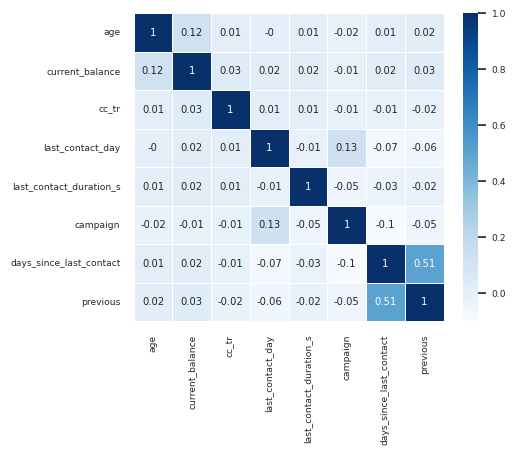

In [ ]:
if run['all'] or run['data_exploration']:
    df_matrix = df.corr().round(2)
    sns.set(font_scale=0.6)
    plt.figure(figsize=(5,4))
    sns.heatmap(df_matrix, annot=True, cmap='Blues', linecolor='white', linewidth=0.5)

### 2.4 Check numerical data for positive & negative values 

In [ ]:
if run['all'] or run['data_exploration']:

    def check_signs(dataframe, categorical_columns):
        number_signs = [((dataframe[column] > 0).sum(), (dataframe[column] == 0).sum(), (dataframe[column] < 0).sum()) for column in dataframe.columns if column not in categorical_columns if dataframe[column].dtype != 'object' if dataframe[column].dtype != 'datetime64[ns]']
        df_result = pd.DataFrame(
            number_signs, 
            index = [column for column in dataframe.columns if column not in categorical_columns if dataframe[column].dtype != 'object' if dataframe[column].dtype != 'datetime64[ns]'],
            columns = ['positive values', 'zero values', 'negative values']
            )
        print(df_result)

    check_signs(df, categorical_columns)

                         positive values  zero values  negative values
age                                 8000            0                0
current_balance                     6936          567              497
last_contact_day                    8000            0                0
last_contact_duration_s             7999            0                1
campaign                            8000            0                0
days_since_last_contact             2042            0             5958
previous                            2042         5958                0


## 3. Data cleaning

1. **Nominal vs Ordinal Categorical data.** Within categorical data better to replace ordinal categorical data with sequential numbers to maintain the ordinal nature of the data. Nominal categorical data best left to be encoded using one hot encoding to not introduce any ordering to the data.
2. **Missing samples.** Check for missing values in the dataset.
3. **Datetime datatype.** Need to decide what to do with datetime datatypes. Can just replace with sequential numbers (e.g. days of the month or months of the year) or convert to the datetime datatype (e.g. timestamps).

### 3.1 Make corrections

Stirling Bank:

1. Fix corrupt string value in 'last_contact_month': remove row with data incorrectly input as 'j' for month.

2. Fix corrupt string value in 'has_loan': replace data incorrectly input as 'n' with 'no' to match feature categories.

3. Fix corrupt string value in 'last_contact': replace data incorrectly input as 'cell' with 'cellular' to match feature categories.

4. Fix negative values in 'last_contact_duration_s' to positive values.

5. Fix negative values in 'days_since_last_contact' to positive values.

World of Bargains:

1. Fix corrupt strings in 'Car park' data by replacing 'Y' and 'N' with 'Yes' and 'No'.
2. Correct 'Location' data by adding 'Village' to 'Shopping Centre'.
3. Remove negative value in 'Staff' column.

In [ ]:
if run['all'] or run['data_exploration'] or run['benchmark_models'] or run['experiment'] or run['final_test']:
    import warnings
    warnings.filterwarnings('error')

    if experiment_parameters['dataset'] == 'bank-tr.csv':
        # surpress SettingWithCopyWarning
        pd.options.mode.chained_assignment = None

        first_feature = 'last_contact_month'
        if experiment_parameters['experiment_parameters']['feature_selection'][first_feature]:
            print(f"---------- remove error sample in {first_feature} ----------")
            print(f"Before {first_feature} (fix corrupt string by removing 'j'):\n{df[first_feature].value_counts()}\n")
            df = df[df[first_feature].str.len() > 2]
            print(f"After {first_feature} (no more 'j' in corrected data):\n{df[first_feature].value_counts()}\n")

        second_feature = 'has_loan'
        if experiment_parameters['experiment_parameters']['feature_selection'][second_feature]:
            print(f"---------- replace 'n' values in {second_feature} column ----------")
            print(f"Before {second_feature} (fix corrupt string by replacing 'n' for 'no'):\n{df[second_feature].value_counts()}\n")
            df.loc[df[second_feature] == 'n', second_feature] = 'no'
            print(f"After {second_feature} (no more 'n' in corrected data):\n{df[second_feature].value_counts()}\n")

        third_feature = 'last_contact'
        if experiment_parameters['experiment_parameters']['feature_selection'][third_feature]:
            print(f"---------- replace 'cell' with 'cellular' in {third_feature} column ----------")
            print(f"Before {third_feature} (fix corrupt string by replacing 'cell' for 'cellular'):\n{df[third_feature].value_counts()}\n")
            df.loc[df[third_feature] == 'cell', third_feature] = 'cellular'
            print(f"After {third_feature} (no more 'cell' in corrected data):\n{df[third_feature].value_counts()}\n")

        fourth_feature = 'current_balance'
        if experiment_parameters['experiment_parameters']['feature_selection'][fourth_feature]:
            print(f"---------- remove negative values in {fourth_feature} column ----------")
            print(f"Before {fourth_feature} (change negative values to positive values):\n   Number of negative values: {(df[fourth_feature] < 0).sum()}\n")
            df.loc[df[fourth_feature] < 0, fourth_feature] = df[fourth_feature].abs()
            print(f"After {fourth_feature} (no more negative values and only positive values in corrected data):\n   Number of negative values: {(df[fourth_feature] < 0).sum()}\n")

        fifth_feature = 'last_contact_duration_s'
        if experiment_parameters['experiment_parameters']['feature_selection'][fifth_feature]:
            print(f"---------- remove negative values in {fifth_feature} column ----------")
            print(f"Before {fifth_feature} (change negative values to positive values):\n   Number of negative values: {(df[fifth_feature] < 0).sum()}\n")
            df.loc[df[fifth_feature] < 0, fifth_feature] = df[fifth_feature].abs()
            print(f"After {fifth_feature} (no more negative values and only positive values in corrected data):\n   Number of negative values: {(df[fifth_feature] < 0).sum()}\n")

        sixth_feature = 'days_since_last_contact'
        if experiment_parameters['experiment_parameters']['feature_selection'][sixth_feature]:
            print(f"---------- remove negative values in {sixth_feature} column ----------")
            print(f"Before {sixth_feature} (change negative values to positive values):\n   Number of negative values: {(df[sixth_feature] < 0).sum()}\n")
            df.loc[df[sixth_feature] < 0, sixth_feature] = df[sixth_feature].abs()
            print(f"After {sixth_feature} (no more negative values and only positive values in corrected data):\n   Number of negative values: {(df[sixth_feature] < 0).sum()}\n")

    elif dataset == 'storedata.csv':
        # surpress SettingWithCopyWarning
        pd.options.mode.chained_assignment = None

        first_feature = 'Car park'
        if experiment_parameters[dataset]['feature_selection'][first_feature]:
            print(f"---------- replace 'Y' and 'N' values in {first_feature} column ----------")
            print(f"Before {first_feature} (fix corrupt strings by replacing 'Y' for 'Yes' and 'N' for 'No'):\n{df[first_feature].value_counts()}\n")
            df.loc[df[first_feature] == 'Y', first_feature] = 'Yes'
            df.loc[df[first_feature] == 'N', first_feature] = 'No'
            print(f"After {first_feature} (no more 'Y' and 'N' in corrected data):\n{df[first_feature].value_counts()}\n")

        second_feature = 'Location'
        if experiment_parameters[dataset]['feature_selection'][second_feature]:
            print(f"---------- reallocate 'Village' to 'Shoping Centre' in {second_feature} column ----------")
            print(f"Before {second_feature} (consolidate 'Village' to 'Shopping Centre'):\n{df[second_feature].value_counts()}\n")
            df.loc[df[second_feature] == 'Village', second_feature] = 'Shopping Centre'
            print(f"After {second_feature} (no more 'Village' in corrected data):\n{df[second_feature].value_counts()}\n")

        third_feature = 'Staff'
        if experiment_parameters[dataset]['feature_selection'][third_feature]:        
            print(f"---------- remove negative value in {third_feature} column ----------")
            print(f"Before {third_feature} (change negative value to positive value):\n   Number of negative values: {(df[third_feature] < 0).sum()}\n")
            df.loc[df[third_feature] < 0, third_feature] = df[third_feature].abs()
            print(f"After {third_feature} (no more negative value and only positive values in corrected data):\n   Number of negative values: {(df[third_feature] < 0).sum()}\n")

---------- remove error sample in last_contact_month ----------
Before last_contact_month (fix corrupt string by removing 'j'):
may    2037
jul    1087
aug    1064
jun     863
nov     669
apr     660
feb     552
oct     302
jan     255
sep     240
mar     194
dec      76
j         1
Name: last_contact_month, dtype: int64

After last_contact_month (no more 'j' in corrected data):
may    2037
jul    1087
aug    1064
jun     863
nov     669
apr     660
feb     552
oct     302
jan     255
sep     240
mar     194
dec      76
Name: last_contact_month, dtype: int64

---------- replace 'n' values in has_loan column ----------
Before has_loan (fix corrupt string by replacing 'n' for 'no'):
no     6963
yes    1031
n         5
Name: has_loan, dtype: int64

After has_loan (no more 'n' in corrected data):
no     6968
yes    1031
Name: has_loan, dtype: int64

---------- replace 'cell' with 'cellular' in last_contact column ----------
Before last_contact (fix corrupt string by replacing 'cell' for 'c

In [ ]:
if run['all'] or run['data_exploration']:
    check_erroneous_data(df, categorical_columns)

---------------- town ----------------
           p_frequency  n_frequency
town                               
London            5.9%          472
Birmingham        4.4%          353
Glasgow           4.2%          335
Bristol           3.3%          260
Liverpool         2.9%          233
...                ...          ...
Crawley           0.7%           52
Dundee            0.7%           52
Aberdeen          0.7%           52
Exeter            0.6%           50
Bradford          0.6%           46

[101 rows x 2 columns] 

---------------- country ----------------
         p_frequency  n_frequency
country                          
UK             99.9%         7994
France          0.0%            2
Germany         0.0%            1
Portugal        0.0%            1
USA             0.0%            1 

---------------- job ----------------
              p_frequency  n_frequency
job                                   
management          22.8%         1824
blue-collar         16.9%     

In [ ]:
if run['all'] or run['data_exploration']:
    display(df.head(10).style)

,town,country,age,job,married,education,defaulted?,current_balance,housing,has_loan,last_contact,cc_tr,last_contact_day,last_contact_month,last_contact_duration_s,campaign,days_since_last_contact,previous,poutcome,made_deposit
0,Crawley,UK,39,management,married,tertiary,no,190,no,yes,unknown,1,11,jun,893,8,1,0,unknown,yes
1,Southend-on-Sea,UK,53,housemaid,married,primary,no,362,no,no,cellular,1,28,jul,1169,2,1,0,unknown,yes
2,Gillingham,UK,79,retired,divorced,primary,no,2787,no,no,telephone,5,13,jul,617,1,377,1,success,yes
3,Gateshead,UK,43,services,single,secondary,no,550,yes,no,cellular,4,13,may,107,2,1,0,unknown,no
4,Eastbourne,UK,35,technician,single,secondary,no,344,no,no,cellular,2,27,aug,519,16,1,0,unknown,yes
5,Cambridge,UK,24,student,single,secondary,no,139,no,no,cellular,1,9,sep,430,4,1,0,unknown,yes
6,Eastbourne,UK,49,blue-collar,divorced,primary,no,24,yes,no,cellular,5,11,may,701,1,362,1,success,yes
7,London,UK,54,self-employed,single,tertiary,no,384,no,yes,cellular,4,27,may,200,1,1,0,unknown,yes
8,Colchester,UK,29,services,married,primary,no,102,no,no,unknown,4,4,jul,134,1,1,0,unknown,no
9,Bristol,UK,56,blue-collar,single,secondary,no,1187,yes,no,cellular,2,5,feb,47,2,1,0,unknown,no


1. **Describe data prior to modeling process:** use bar charts for categorical data and histograms for numerical to display data.

2. **Pre-process data:** correct mis-typed entries by making specific changes or using rules to correct data.

3. **Select data used to build model:** examine pre-processed data to determine which features will be used in the modeling process. 

Also, check occurrences of each unique value to select features.

1. Town data too sparse (101 unique values over 8000 samples).

2. Country data seems irrelevant as almost all of data for the 'UK'.

3. Jobs has several categories so may want to run model with and without jobs categories.

4. Defaulted should be low number so looks ok.

5. Last contact erroneous data given large count of 'unknown' category and most count in 'cellular' category. (may not be the case)

6. Poutcome is useless data given large count in the 'unknown' category as well as redundant since categories include both an 'unknown' and 'other' category alongside 'successful' and 'failure' categories. (may not be the case)

7. Campaign and Previous don't know if numerical or categorical data so try with and without.

8. cc_tr don't know what this feature means but seems like 5 categories. Try as integer now but also try as categorical later.



### 3.2 Histograms

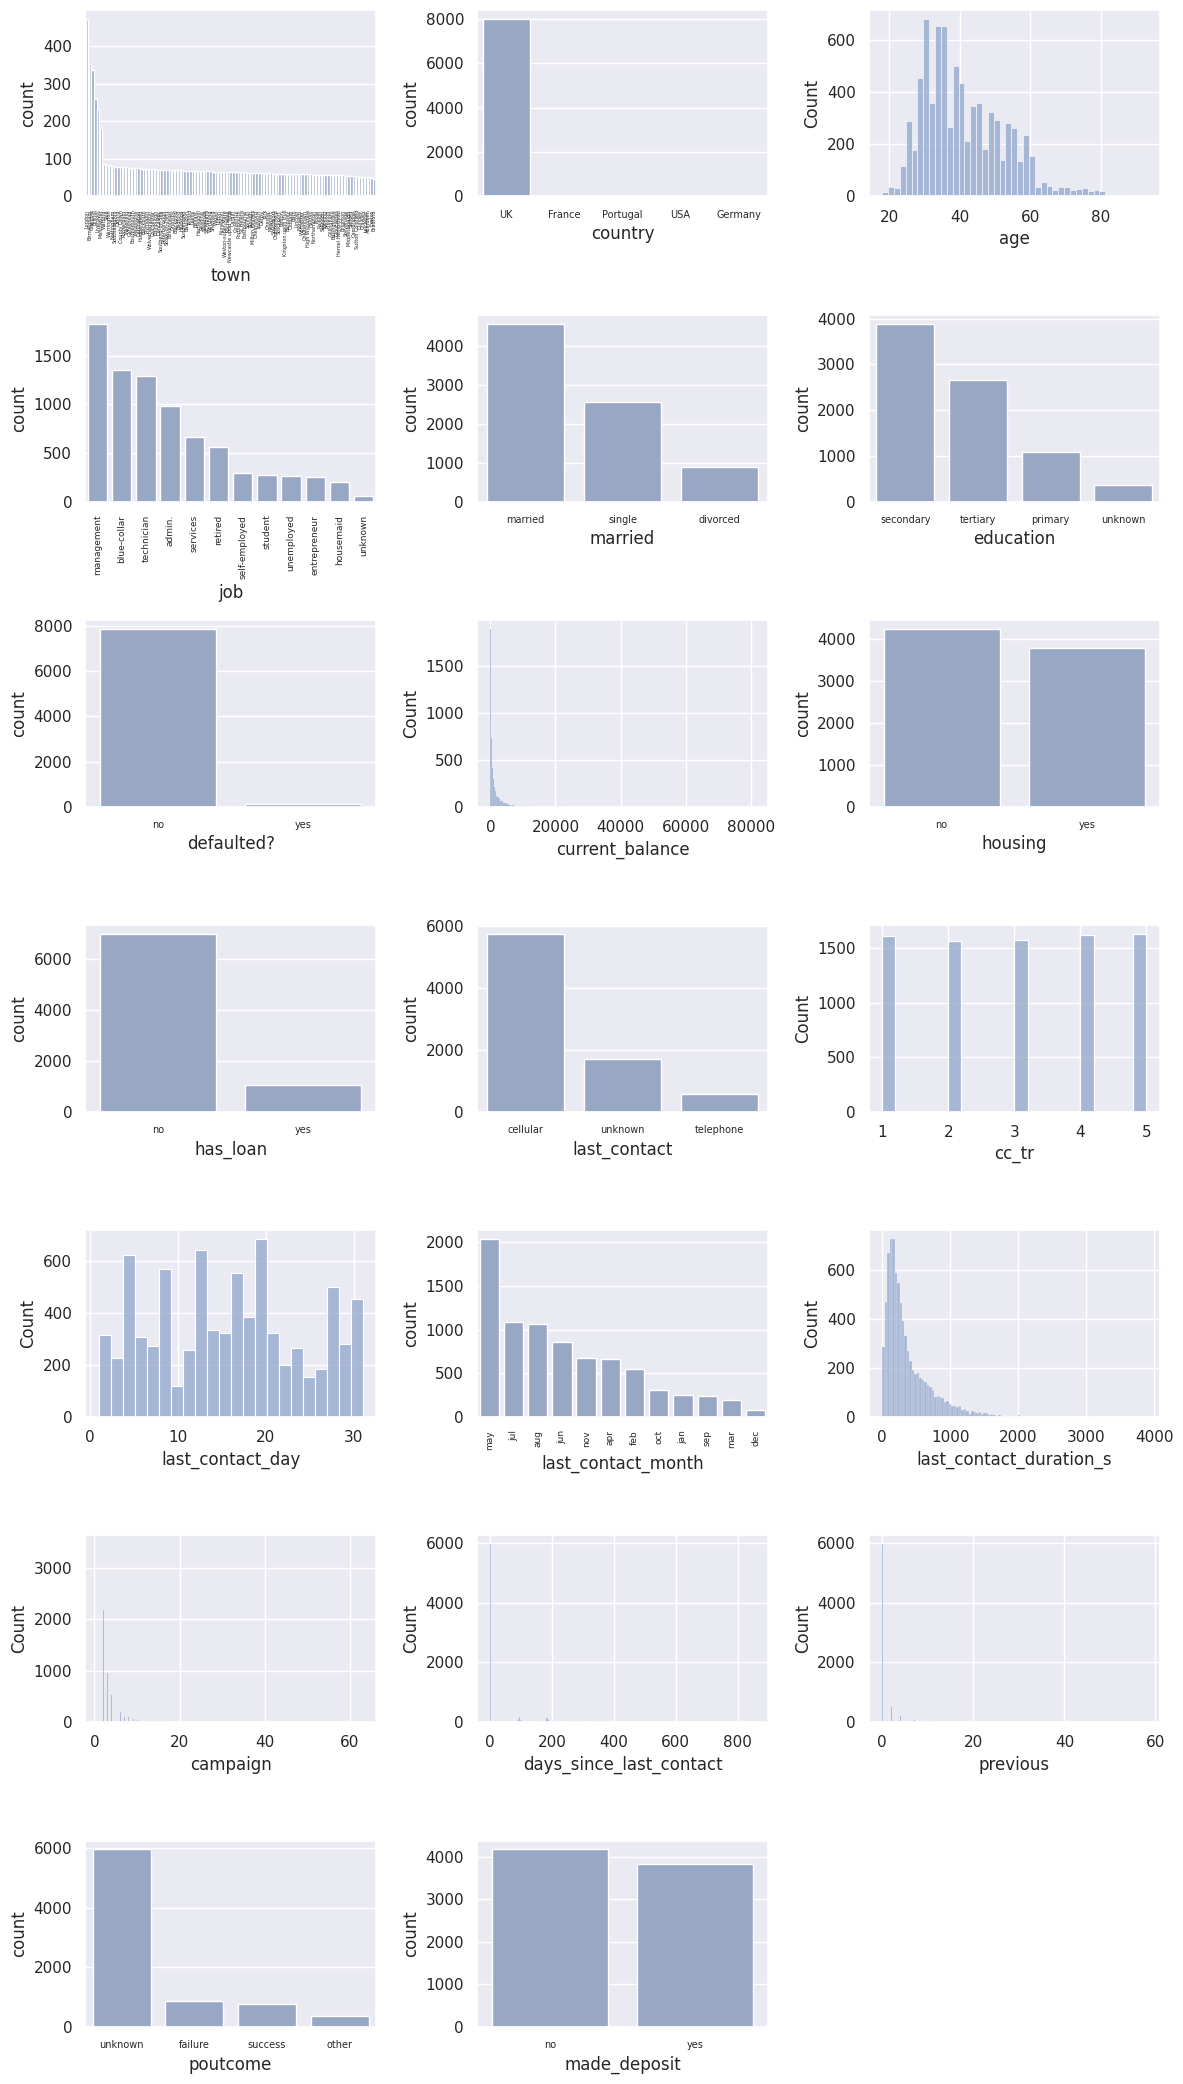

In [ ]:
if run['all'] or run['data_exploration']:
    
    def view_charts(chart,cols,font,dataframe):
        rows = math.ceil(len(dataframe.columns)/cols)
        sns.set(font_scale=font)
        plt.figure(figsize=((cols*chart[0]),(rows*chart[1])))
        for i, feature in enumerate(dataframe.columns):
            if dataframe[feature].dtype == 'object':
                plt.subplot(rows,cols,i+1)
                plot = sns.countplot(data=dataframe,x=dataframe[feature],order=dataframe[feature].value_counts().index,color='#8FA5CC',edgecolor=None)
                plot.set_xticklabels(plot.get_xticklabels(),fontsize=7)
                if (len(plot.get_xticklabels()) > 5):
                    font_adj = round(len(plot.get_xticklabels())/15) * 0.5
                    plot.set_xticklabels(plot.get_xticklabels(),rotation=90,fontsize=max((7-font_adj),2))
            else:
                plt.subplot(rows,cols,i+1)
                sns.histplot(dataframe[feature],x=dataframe[feature],color='#8FA5CC',edgecolor=None)
        plt.tight_layout()
        plt.show()

    chart,cols,font = (4,3),3,1
    view_charts(chart,cols,font,df)

## 4. Data preparation

### 4.1 Set features & targets

In [ ]:
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    def set_features_target(dataframe, target):
        X = dataframe.drop(target,axis=1)
        y = dataframe[target]
        if target in categorical_columns:
            categorical_columns.remove(target)
        return X, y

    target = experiment_parameters['experiment_parameters']['target']
    X, y = set_features_target(df, target)
    display(X.shape)
    display(y.shape)

### 4.2 Split dataset into train, test data & set kfold

In [ ]:
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    def setup_dataset(X, y, n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)    
        skf = StratifiedKFold(n_splits=n_splits, shuffle=False)
        return X_train, X_test, y_train, y_test, skf

    n_splits = experiment_parameters['experiment_parameters']['n_splits']
    X_train, X_test, y_train, y_test, skf = setup_dataset(X, y, n_splits)
    display(X_train.shape)
    display(y_train.shape)
    display(X_test.shape)
    display(y_test.shape)


## 5. Feature Engineering

### 5.1 Encoding variables

In [ ]:
# encoding using sklearn's OneHotEncoder (not being used)
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import LabelBinarizer

    def encode_dataset_skl(X,y,categorical_columns):
        column_transformer = ColumnTransformer(transformers=[
            ('ohe', OneHotEncoder(), categorical_columns)
        ], remainder='passthrough')
        encoded_features = column_transformer.fit_transform(X)
        X = pd.DataFrame(
            encoded_features, 
            # columns=column_transformer.get_feature_names_out(),
            # index=X.index
        )
        y = LabelBinarizer().fit_transform(y)
        display(X)
        display(y)
        return X, y

In [ ]:
# encoding using pandas get_dummies (being used)
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    def encode_dataset(X, y):
        X = pd.get_dummies(X, prefix_sep='_', columns=categorical_columns, drop_first=True)
        y = pd.get_dummies(y, prefix_sep='_', drop_first=True)
        return X, y

### 5.2 Normalise dataset

In [ ]:
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    from sklearn.preprocessing import MinMaxScaler

    def normalise_dataset(X, y):
        scaled_features = MinMaxScaler().fit_transform(X)
        X = pd.DataFrame(scaled_features, columns=X.columns)
        scaled_target = MinMaxScaler().fit_transform(y)
        y = scaled_target[:,0]
        return X, y

### 5.3 Run preprocessing

In [ ]:
if run['all'] or run['benchmark_models'] or run['experiment'] or run['final_test']:

    def run_preprocessing(X,y):
        X_encode, y_encode = encode_dataset(X, y)
        X_normalise, y_normalise = normalise_dataset(X_encode, y_encode)
        return X_normalise, y_normalise

## 6. Benchmark models

### 6.1 Model selection: null accuracy & cross validation scores of default models

In [ ]:
if run['all'] or run['benchmark_models']:

    def run_benchmark_models(X, y, cv, scoring, **models):
        X_train, y_train = run_preprocessing(X, y)
        print(f"Null_accuracy: {max(y_train.mean(), 1 - y_train.mean())}")
        for model in models:
            estimator = model_mapping[experiment_parameters['selected_classifiers'][model]['default']]
            scores = cross_validate(estimator, X_train, y_train, cv=cv,scoring=('accuracy','precision','recall','f1','roc_auc'), n_jobs=-1)
            accuracy = scores['test_accuracy'].mean()
            precision = scores['test_precision'].mean()
            recall = scores['test_recall'].mean()
            f1 = scores['test_f1'].mean()
            auc = scores['test_roc_auc'].mean()
            print(f"{model} cross validation scores:")
            print(f"    Accuracy: {accuracy:<10.6f} Precision: {precision:<10.6f} Recall: {recall:<10.6f} F1: {f1:<10.6f} AUC: {auc:0.6f}")

    n_splits = experiment_parameters['experiment_parameters']['n_splits']
    scoring = experiment_parameters['experiment_parameters']['scoring']
    run_benchmark_models(X=X_train, y=y_train, cv=n_splits, scoring=scoring, DT='DT', MLP='MLP', LR='LR')

## 7. Model training

### 7.1 Run experiment

model = classifier + hyperparameter combination (+ data processing pipeline)

for each classifer
    - do GridSearch with cross-fold validation using that classifier's parameter grid
    - extract the best model for each classifier
    - save the results in that classifier's dictionary

choose the overall best model -- this is the result of this experiment

In [ ]:
if run['all'] or run['experiment']:

    import matplotlib.gridspec as gridspec

    def get_charts(selection,classifier,X,y,n_splits):
        y_pred = cross_val_predict(classifier, X, y, cv=n_splits)
        conf_matrix = confusion_matrix(y, y_pred)
        y_pred_proba = cross_val_predict(classifier, X, y, cv=n_splits, method='predict_proba')
        # use probability of 1 for roc_curve (predict_proba returns probability for both 0 and 1)
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])

        sns.set_theme(context='notebook',font_scale=0.6, style='darkgrid')
        cm = 1/2.54
        a4_dims = (17*cm, 7*cm)
        fig = plt.figure(figsize=a4_dims, constrained_layout=True)
        grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)
        ax0 = fig.add_subplot(grid[0,0])
        ax1 = fig.add_subplot(grid[0,1])
        matrix = sns.heatmap(
            conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            square=True, 
            xticklabels=['Negative','Positive'], 
            yticklabels=['Negative','Positive'],
            ax=ax0
            )
        matrix.set_title(f"{selection} confusion matrix")
        matrix.set_xlabel("Actual")
        matrix.set_ylabel("Predicted")
        roc = sns.lineplot(
            x=fpr, 
            y=tpr, 
            ax=ax1
            )
        roc.set_xlim(0.0, 1.0)
        roc.set_ylim(0.0, 1.0)
        roc.set_title(f"{selection} ROC curve")
        roc.set_xlabel("False positive rate (1 - Specificity)")
        roc.set_ylabel("True positive rate (Sensitivity)")
        plt.savefig(
            f"/work/deepnote_exports/{selection}.png",
            dpi=400,
            bbox_inches='tight',
            pad_inches=0.3
        )
        plt.show()
        return conf_matrix

    def get_cross_val_scores(classifier, X, y, n_splits):
        scores = cross_validate(classifier, X, y, cv=n_splits,scoring=('accuracy','precision','recall','f1','roc_auc'), n_jobs=-1)
        accuracy = scores['test_accuracy'].mean()
        precision = scores['test_precision'].mean()
        recall = scores['test_recall'].mean()
        f1 = scores['test_f1'].mean()
        auc = scores['test_roc_auc'].mean()
        return accuracy, precision, recall, f1, auc

    def run_experiment(X_train, y_train,n_splits,scoring):
        experiment_results = {}
        experiment_models = {}
        X_train, y_train = run_preprocessing(X_train, y_train)
        for selection in experiment_parameters['selected_classifiers']:
            if experiment_parameters['selected_classifiers'][selection]['include']:
                classifier = GridSearchCV(
                    estimator=model_mapping[experiment_parameters['selected_classifiers'][selection]['default']],
                    param_grid=experiment_parameters['selected_classifiers'][selection]['params'],
                    scoring=scoring,
                    cv=skf,
                    n_jobs=-1,
                    verbose=1
                    )
                classifier.fit(X_train,y_train)
                best_estimator = classifier.best_estimator_
                accuracy, precision, recall, f1, auc = get_cross_val_scores(best_estimator, X_train, y_train, n_splits)
                print(f"{selection} experiment best results:")
                print(f"    Experiment best score ({scoring}): {classifier.best_score_:0.6f}")
                print(f"{selection} cross validation scores:")
                print(f"    Accuracy: {accuracy:<10.6f} Precision: {precision:<10.6f} Recall: {recall:<10.6f} F1: {f1:<10.6f} AUC: {auc:0.6f}")
                conf_matrix = get_charts(selection,best_estimator,X_train,y_train,n_splits)
                scores = {
                    'mean_cross_val_accuracy': accuracy,
                    'mean_cross_val_precision': precision,
                    'mean_cross_val_recall': recall,
                    'mean_cross_val_f1': f1,
                    'mean_cross_val_auc': auc,
                }
                matrix = {
                    'TN': int(conf_matrix[0][0]),
                    'FP': int(conf_matrix[0][1]),
                    'FN': int(conf_matrix[1][0]),
                    'TP': int(conf_matrix[1][1])
                }
                best_results = {
                    'best_params': classifier.best_params_,
                    'best_score': classifier.best_score_,
                    'cross_val_scores': scores,
                    'cross_val_confusion_matrix': matrix
                }
                experiment_results[selection] = best_results
                experiment_models[selection] = best_estimator
        return experiment_results, experiment_models
    
    n_splits = experiment_parameters['experiment_parameters']['n_splits']
    scoring = experiment_parameters['experiment_parameters']['scoring']
    experiment_scores, experiment_models = run_experiment(X_train, y_train, n_splits, scoring)

### 7.2 Feature importance

In [ ]:
if run['all'] or (run['experiment'] and run['_incl_analyse_results']):

    def analyse_decision_tree(best_decision_tree,threshold,X,include_tree=False):
        fig_dt = plt.figure(figsize=(8.3,11.7))
        sns.set_theme(context='notebook',font_scale=1, style='darkgrid')
        plt.subplot(2,1,1)
        feature_values = best_decision_tree.feature_importances_
        feature_names = best_decision_tree.feature_names_in_
        df_features = pd.DataFrame(feature_values[feature_values>threshold], index=feature_names[feature_values>threshold]).sort_values(0,ascending=False)
        plot = sns.barplot(
            data=df_features,
            x=df_features[0],
            y=df_features.index,
            color='steelblue',
            ).set(title='Decision tree feature importance', xlabel=None)
        if include_tree:
            plt.subplot(2,1,2)
            plot = tree.plot_tree(
                best_decision_tree,
                feature_names=feature_names,
                class_names={0: 'negative', 1: 'positive'},
                filled=True,
                fontsize=5,
            )
        plt.tight_layout()
        plt.savefig(
            f"/work/deepnote_exports/DT_features.png",
            dpi=400,
            pad_inches=0.3
        )
        plt.show()
        return fig_dt

    def analyse_logistic_regression(best_logistic_regression,pos_threshold,neg_threshold,X):
        fig_lr = plt.figure(figsize=(8.3,11.7))
        sns.set_theme(context='notebook',font_scale=1, style='darkgrid')
        plt.subplot(2,1,1)
        feature_values = best_logistic_regression.coef_[0]
        feature_names = best_logistic_regression.feature_names_in_
        df_features = pd.DataFrame(feature_values[(feature_values>pos_threshold) | (feature_values<neg_threshold)], index=feature_names[(feature_values>pos_threshold) | (feature_values<neg_threshold)]).sort_values(0,ascending=False)
        sns.barplot(
            data=df_features,
            x=df_features[0],
            y=df_features.index,
            color='steelblue',
            ).set(title='Logistic regression feature importance', xlabel=None)
        plt.tight_layout()
        plt.savefig(
            f"/work/deepnote_exports/LR_features.png",
            dpi=400,
            pad_inches=0.3
        )
        plt.show()
        return fig_lr

    feature_charts = {}
    for best_model in experiment_models:
        if best_model == 'DT':
            dt_features = analyse_decision_tree(experiment_models[best_model],0.000,X_train,include_tree=True)
            feature_charts[best_model] = dt_features
        elif best_model == 'LR':
            lr_features = analyse_logistic_regression(experiment_models[best_model],0.5,-0.5,X_train)
            feature_charts[best_model] = lr_features

### 7.3 Save experiment results: generate results dictionary

In [ ]:
if run['all'] or (run['experiment'] and run['_incl_save_experiment']):

    def get_new_experiment_results(experiment_name, experiment_parameters, experiment_scores):
        new_experiment = experiment_parameters.copy()
        new_experiment['experiment_name'] = experiment_name
        best_results = {}
        for selection in experiment_scores:
            new_experiment['selected_classifiers'][selection]['best_results'] = experiment_scores[selection]
        return new_experiment

    experiment_name = 'exp_01'
    new_experiment_parameters = get_new_experiment_results(experiment_name, experiment_parameters, experiment_scores)

### 7.4 Save experiment results: save as pdf

In [ ]:
if run['all'] or (run['experiment'] and run['_incl_save_experiment']):
    
    import os
    from fpdf import FPDF

    def get_pdf_filename(experiment_name):
        stack = [1]
        while stack:
            cur = stack.pop()
            if os.path.isfile('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'({}).pdf'.format(cur)):
                next = cur + 1
                stack.append(next)
            else:
                return '/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'({}).pdf'.format(cur)

    class PDF(FPDF):
        def __init__(self, orientation, unit, format):
            super().__init__(orientation=orientation, unit=unit, format=format)
        def header(self):
            self.set_font('Helvetica', '', 6)
            self.cell(w=12, h=0.5, txt='/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'_example.pdf', border=0, ln=0)
            self.set_font('Helvetica', '', 8)
            self.cell(w=4, h=0.5, txt=pd.Timestamp.now().strftime('Date: %Y/%m/%d'), border=0, align='R', ln=1)
        def footer(self):
            self.set_y(-1.5)
            self.set_font('Helvetica', '', 8)
            self.cell(w=0, h=0.5, txt=f'Page {self.page_no()}/{{nb}}', ln=0, align='C')

    def save_experiment_as_pdf(new_experiment_parameters, **feature_charts):
        cell_title = 1.4
        cell_high = 0.5
        cell_low = 0.3

        pdf = PDF(orientation='P', unit='cm', format='A4')
        pdf.set_margins(3,2,2)

        for selection in new_experiment_parameters['selected_classifiers']:
            if new_experiment_parameters['selected_classifiers'][selection]['include']:
                pdf.add_page()
                pdf.ln(cell_title)
        
                pdf.set_font('Helvetica', 'B', 24)
                pdf.cell(w=0, h=cell_title, txt=f"Dataset: {new_experiment_parameters['dataset']}", border=0, ln=1)
                pdf.set_font('Helvetica', '', 16)
                pdf.cell(w=0, h=cell_low, txt=f"Experiment: {new_experiment_parameters['experiment_name']}", border=0, ln=1)
                pdf.ln(cell_title)
            
                pdf.set_font('Helvetica', 'U', 12)
                pdf.cell(w=0, h=cell_low, txt=f"{model_mapping[selection]}", border=0, ln=1)
                pdf.ln(cell_high)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt=f"{selection} experiment best results:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                best_score = new_experiment_parameters['selected_classifiers'][selection]['best_results']['best_score']
                pdf.cell(w=0, h=cell_low, txt=f"    Experiment best score ({new_experiment_parameters['experiment_parameters']['scoring']}): {best_score:0.6f}", border=0, ln=1)
                
                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt=f"{selection} cross validation scores:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                scores = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
                for score, name  in zip(new_experiment_parameters['selected_classifiers'][selection]['best_results']['cross_val_scores'],scores):
                    pdf.cell(w=0, h=cell_low, txt=f"    {name}: {new_experiment_parameters['selected_classifiers'][selection]['best_results']['cross_val_scores'][score]:<10.6f}", border=0, ln=1)
                
                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt=f"{selection} confusion matrix & ROC curve:", border=0, ln=1)
                pdf.image('/work/deepnote_exports/' + selection+'.png', x=2.8, w=16, type='PNG')
                
                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt="Best classifier:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                pdf.cell(w=0, h=cell_low, txt=f"    {str(model_mapping[new_experiment_parameters['selected_classifiers'][selection]['default']])}", border=0, ln=1)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt="Best hyperparameters:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                for hyperparam, value in new_experiment_parameters['selected_classifiers'][selection]['best_results']['best_params'].items():
                    pdf.cell(w=0, h=cell_low, txt=f"    {hyperparam}: {value}", border=0, ln=1)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt="Grid search hyperparameters:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                for param, value in new_experiment_parameters['selected_classifiers'][selection]['params'].items():
                    pdf.cell(w=0, h=cell_low, txt=f"    {param}: {value}", border=0, ln=1)

                pdf.add_page()
                pdf.ln(cell_title)

                pdf.set_font('Helvetica', 'B', 24)
                pdf.cell(w=0, h=cell_title, txt=f"Dataset: {new_experiment_parameters['dataset']}", border=0, ln=1)
                pdf.set_font('Helvetica', '', 16)
                pdf.cell(w=0, h=cell_low, txt=f"Experiment: {new_experiment_parameters['experiment_name']}", border=0, ln=1)
                pdf.ln(cell_title)

                pdf.set_font('Helvetica', 'U', 12)
                pdf.cell(w=0, h=cell_low, txt=f"{model_mapping[selection]}", border=0, ln=1)
                pdf.ln(cell_high)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_high, txt="Experiment parameters:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                settings = list(new_experiment_parameters['experiment_parameters'].items())[:3]
                pdf.cell(w=0, h=cell_low, txt=f"    {settings[0][0]}: {settings[0][1]}", border=0, ln=1)
                pdf.cell(w=0, h=cell_low, txt=f"    {settings[1][0]}: {settings[1][1]}", border=0, ln=1)
                pdf.cell(w=0, h=cell_low, txt=f"    {settings[2][0]}: {settings[2][1]}", border=0, ln=1)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_low, txt="    categorical columns:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                for category in new_experiment_parameters['experiment_parameters']['categorical_columns']:
                    pdf.cell(w=0, h=cell_low, txt=f"        {category}", border=0, ln=1)

                pdf.set_font('Helvetica', 'B', 8)
                pdf.cell(w=0, h=cell_low, txt="    feature selection:", border=0, ln=1)
                pdf.set_font('Helvetica', '', 8)
                for feature, value in new_experiment_parameters['experiment_parameters']['feature_selection'].items():
                    pdf.cell(w=0, h=cell_low, txt=f"        {feature}: {value}", border=0, ln=1)

                if feature_charts and selection in feature_charts:
                    pdf.add_page()
                    pdf.ln(cell_title)
                    pdf.image('/work/deepnote_exports/' + selection +'_features.png', x=2.8, w=16, type='PNG')

        if os.path.isfile('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d')) + experiment_name + '.pdf'):
            filename = get_pdf_filename(experiment_name)
            pdf.output(filename, 'f')
        else:
            pdf.output('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d')) + experiment_name + '.pdf', 'f')

    if run['_incl_analyse_results']:
        save_experiment_as_pdf(new_experiment_parameters, **feature_charts)
    else:
        save_experiment_as_pdf(new_experiment_parameters)

### 7.5 Save experiment results: save as json

In [ ]:
if run['all'] or (run['experiment'] and run['_incl_save_experiment']):

    import os

    def get_filename(experiment_name):
        stack = [1]
        while stack:
            cur = stack.pop()
            if os.path.isfile('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'({}).json'.format(cur)):
                next = cur + 1
                stack.append(next)
            else:
                return '/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'({}).json'.format(cur)

    def save_experiment_as_json(new_experiment_parameters):
        experiment_name = new_experiment_parameters['experiment_name']
        experiment_json = json.dumps(new_experiment_parameters, indent=4)
        if os.path.isfile('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'.json'):
            filename = get_filename(experiment_name)
            with open(filename,'w') as f:
                f.write(experiment_json)
        else:
            with open('/work/deepnote_exports/{}_'.format(pd.Timestamp.now().strftime('%y%m%d'))+experiment_name+'.json','w') as f:    
                f.write(experiment_json)
    
    save_experiment_as_json(new_experiment_parameters)

## 8. Tuning

* set up options for choosing columns to include (you should be able to set True / False or similar to turn on / off each column)
* make sure you are extracting the best score from GridSearch (not just the best parameters) so you can better compare models; you might also want to extract the trained model so that you can run further analysis on the best one (see my last bullet point below)
* download the notebook to your own computer
* run experiments to try to find the best model (feature selection + classifier + hyperparameter combination) — in other words, systematically explore different combinations for feature selection (i.e. which columns to include) and hyper parameter combinations for each classifier, with the aim to find the model with the highest score (from GridSearch) for your chosen metric
* to help you run experiments, you might look into making ‘analysis’ functions to explore a particular trained model e.g. ranking importance of features, reporting more results like those suggested in the Results part of the assignment — these can all help inform your experiments by giving you ideas e.g. of features to drop

Note that while we determined recall is probably more important than precision for this problem, I don’t think you want to use recall as the metric by which you compare models. The reason is that you can easily ‘game’ this e.g. you can get 100% recall by always returning yes. Better metrics would be accuracy or F1-score.

## 9. Final Test

In [ ]:
if run['final_test']:

    def get_charts(selection,classifier,X,y,n_splits):
        y_pred = cross_val_predict(classifier, X, y, cv=n_splits)
        conf_matrix = confusion_matrix(y, y_pred)
        y_pred_proba = cross_val_predict(classifier, X, y, cv=n_splits, method='predict_proba')
        # use probability of 1 for roc_curve (predict_proba returns probability for both 0 and 1)
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])

        sns.set_theme(context='notebook',font_scale=0.6, style='darkgrid')
        cm = 1/2.54
        a4_dims = (17*cm, 7*cm)
        fig = plt.figure(figsize=a4_dims, constrained_layout=True)
        grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.25)
        ax0 = fig.add_subplot(grid[0,0])
        ax1 = fig.add_subplot(grid[0,1])
        matrix = sns.heatmap(
            conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            square=True, 
            xticklabels=['Negative','Positive'], 
            yticklabels=['Negative','Positive'],
            ax=ax0
            )
        matrix.set_title(f"{selection} confusion matrix")
        matrix.set_xlabel("Actual")
        matrix.set_ylabel("Predicted")
        roc = sns.lineplot(
            x=fpr, 
            y=tpr, 
            ax=ax1
            )
        roc.set_xlim(0.0, 1.0)
        roc.set_ylim(0.0, 1.0)
        roc.set_title(f"{selection} ROC curve")
        roc.set_xlabel("False positive rate (1 - Specificity)")
        roc.set_ylabel("True positive rate (Sensitivity)")
        plt.savefig(
            f"/work/deepnote_exports/{selection}.png",
            dpi=400,
            bbox_inches='tight',
            pad_inches=0.3
        )
        plt.show()
        return conf_matrix

    def run_final_test(final_model_name, final_model, X, y, n_splits):
        X_test, y_test = run_preprocessing(X, y)
        scores = cross_validate(final_model, X_test, y_test, cv=n_splits,scoring=('accuracy','precision','recall','f1','roc_auc'), n_jobs=-1)
        accuracy = scores['test_accuracy'].mean()
        precision = scores['test_precision'].mean()
        recall = scores['test_recall'].mean()
        f1 = scores['test_f1'].mean()
        auc = scores['test_roc_auc'].mean()
        print(f"{final_model_name} results:")
        print(f"    Accuracy: {accuracy:<10.6f} Precision: {precision:<10.6f} Recall: {recall:<10.6f} F1: {f1:<10.6f} AUC: {auc:0.6f}")
        conf_matrix = get_charts(final_model_name,final_model,X_test,y_test,n_splits)

    final_model_key = 'LR' # TODO should come from previous_experiment
    final_model_name = 'Final model: LR'

    final_model = model_mapping[final_model_key]
    params = experiment_parameters['selected_classifiers'][final_model_key]['best_results']['best_params']
    final_model.set_params(**params)

    ## generate test results
    n_splits = experiment_parameters['experiment_parameters']['n_splits']
    run_final_test(final_model_name,final_model,X_test,y_test,n_splits)

### TODO

* move experiment options at the beginning into external JSON files (one per experiment, numbered)
* first cell in notebook -- ask the user which experiment they want to run -- then load the options (including which dataset)
* save the graphs after each experiment
* use cross_validate instead of cross_val_score to save time
* run a few experiments
    * use a high-spec machine with n_jobs = -1
    * if still too slow, reduce size of param grids
* include confusion matrix and ROC curve in final test
* together: final test

* pipeline for ohe
* save final test (identify common utility functions)

https://towardsdatascience.com/choosing-the-best-ml-time-series-model-for-your-data-664a7062f418

### Notes

Check accuracy by comparing predictions with actual information using metrics.

Accuracy Score:
(tp + tn) / (tp + fp + tn + fn)
percentage of people we predict correctly (accurately predict yes or no)

Precision Score:
tp / (tp + fp)
"predicted true as percent of actual true"
percentage of people we predict say yes who actually say yes
high precision -> people we call (= people we predicted to say yes) are likely to say yes, but will call less people
high precision -> not going to make the mistake of calling someone who will say no
calls are expensive -> prefer precision

Recall Score:
tp / (tp + fn)
"predicted true as percent of actual true"
fn = people who we predict say no but actually say yes
tp = people who we predict say yes but actually say yes
fn + tp = all the people who would say yes

percentage of people who would say yes who we predict say yes
high recall -> the people who are likely to say yes we are likely to call, but will call more people
high recall -> not going to make the mistake of not calling someone who would have said yes
calls are cheap, customers are more valuable -> prefer recall

Questions:

1. How does training and testing data work with cross-fold validation? 

2. Order to hyperparameters to reduce computing time?

3. Feature selection depends on recursion or classification? (ie, Chi squared only for classification?)

training: train a model, use training data
validation: check quality of model against metrics, using validation data
selection stage: select the best data preparation + model, optimising for chosen metrics
-> danger of overfitting to the (training+validation) data, might not generalise to other data

testing: check quality of model against metrics, using test data
-> report the ability of the selected model to generalise to unseen data
-> must NEVER use testing data to inform model selection (if you do, the generalisation result will not be accurate, it will be overfitted to the testing data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=41af8bd7-a5ed-4334-a2fe-992dcc7ea742' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>